In [ ]:
import pandas as pd
import re

# Load your file
df = pd.read_csv('/content/Ecommerce_dataset.csv')

# Clean text
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text.strip()

df['questions'] = df['questions'].apply(clean_text)

# Split into two columns
split_df = df['questions'].str.extract(r'question (.*?) answer (.*)')
split_df.columns = ['query', 'response']

# Save the cleaned and split version
split_df.to_csv("Cleaned_Split_Ecommerce_dataset.csv", index=False)

# Show result
print(split_df.head())


                                query  \
0         how can i create an account   
1  what payment methods do you accept   
2            how can i track my order   
3          what is your return policy   
4               can i cancel my order   

                                            response  
0  to create an account click on the sign up butt...  
1  we accept major credit cards debit cards and p...  
2  you can track your order by logging into your ...  
3  our return policy allows you to return product...  
4  you can cancel your order if it has not been s...  


Top Keywords in Queries:
i: 69
a: 68
can: 62
product: 51
if: 37
is: 35
it: 31
order: 29
as: 23
listed: 20
Sentiment Counts:
sentiment_label
neutral     57
negative    12
positive    10
Name: count, dtype: int64


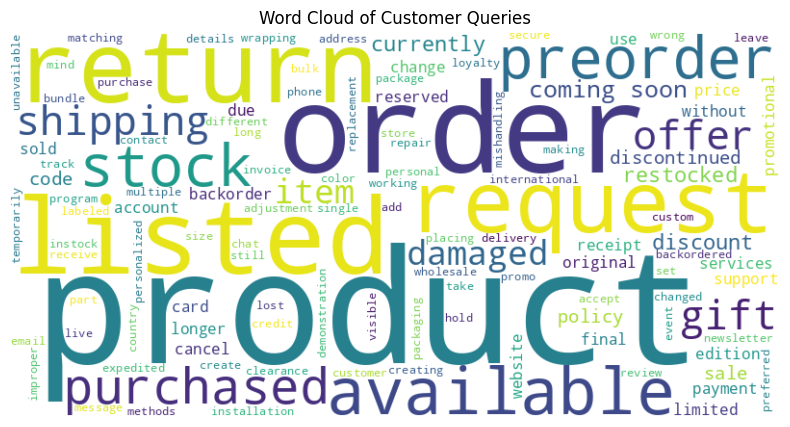

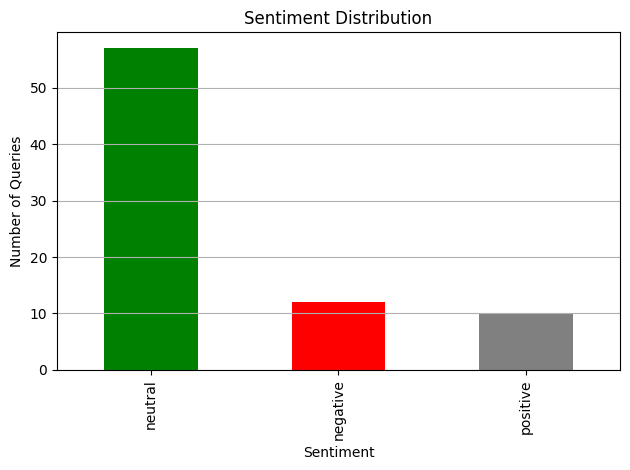

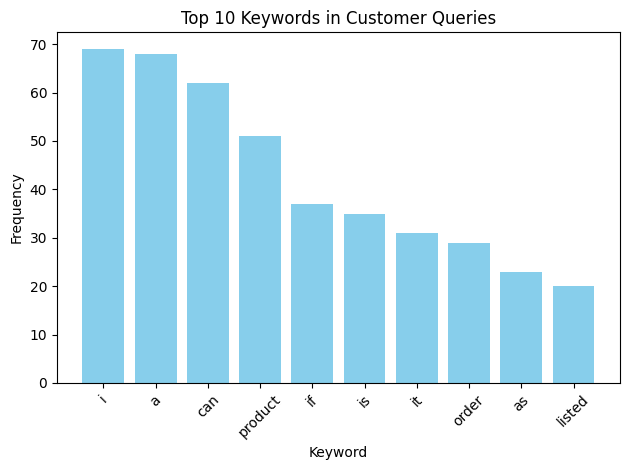

In [ ]:
 #Load the Data
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from textblob import TextBlob

df = pd.read_csv("/content/Cleaned_Split_Ecommerce_dataset.csv")
df.dropna(inplace=True)
df['query'] = df['query'].astype(str).str.lower()

#Most Frequent Query Keywords
from collections import Counter

all_words = " ".join(df['query']).split()
top_keywords = Counter(all_words).most_common(10)

print("Top Keywords in Queries:")
for word, freq in top_keywords:
    print(f"{word}: {freq}")

# Sentiment Analysis
from textblob import TextBlob

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['sentiment'] = df['query'].apply(get_sentiment)
df['sentiment_label'] = df['sentiment'].apply(
    lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral')
)

print("Sentiment Counts:")
print(df['sentiment_label'].value_counts())

#Word Cloud
from wordcloud import WordCloud

text = " ".join(df['query'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Customer Queries")
plt.show()

#Bar Chart for Sentiment Distribution

df['sentiment_label'].value_counts().plot(kind='bar', color=['green', 'red', 'grey'])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Queries")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Bar Chart of Top Keywords
from collections import Counter

# Extract top 10 words from queries
all_words = " ".join(df['query']).split()
top_keywords = Counter(all_words).most_common(10)

# Split for plotting
words, freqs = zip(*top_keywords)

plt.bar(words, freqs, color='skyblue')
plt.xticks(rotation=45)
plt.title("Top 10 Keywords in Customer Queries")
plt.xlabel("Keyword")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.utils import resample

# Load your cleaned and labeled data
df = pd.read_csv("/content/Cleaned_Split_Ecommerce_dataset.csv")

# Function to map responses to intent labels
def map_response_to_intent(response):
    response = str(response).lower()
    if 'order' in response and ('shipped' in response or 'delivered' in response or 'tracking' in response):
        return 'order_status'
    elif 'return' in response or 'refund' in response:
        return 'return_policy'
    elif 'cancel' in response:
        return 'cancel_order'
    elif 'payment' in response or 'card' in response:
        return 'payment_issue'
    elif 'delivery' in response or 'late' in response:
        return 'delivery_info'
    elif 'account' in response or 'login' in response:
        return 'account_help'
    elif 'product' in response or 'available' in response or 'stock' in response:
        return 'product_info'
    else:
        return 'other'

# Apply the function to create the 'intent' column
df['intent'] = df['response'].apply(map_response_to_intent)

# For this example, we assume you have: 'query' and 'intent' columns
df = df[['query', 'intent']]
df.dropna(inplace=True)

# Balance the dataset using upsampling
balanced_df = pd.DataFrame()
for label in df['intent'].unique():
    group = df[df['intent'] == label]
    upsampled = resample(group, replace=True, n_samples=df['intent'].value_counts().max(), random_state=42)
    balanced_df = pd.concat([balanced_df, upsampled])

# Shuffle the balanced dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    balanced_df['query'], balanced_df['intent'], test_size=0.2, random_state=42)

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Predict
y_pred = model.predict(X_test_tfidf)

# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))


Classification Report:
               precision    recall  f1-score   support

 account_help       1.00      1.00      1.00         5
 cancel_order       1.00      1.00      1.00         5
delivery_info       1.00      1.00      1.00         6
 order_status       0.86      1.00      0.92         6
        other       0.40      0.67      0.50         3
payment_issue       1.00      1.00      1.00         9
 product_info       1.00      0.50      0.67         6
return_policy       1.00      1.00      1.00         5

     accuracy                           0.91        45
    macro avg       0.91      0.90      0.89        45
 weighted avg       0.94      0.91      0.91        45



<Figure size 1000x600 with 0 Axes>

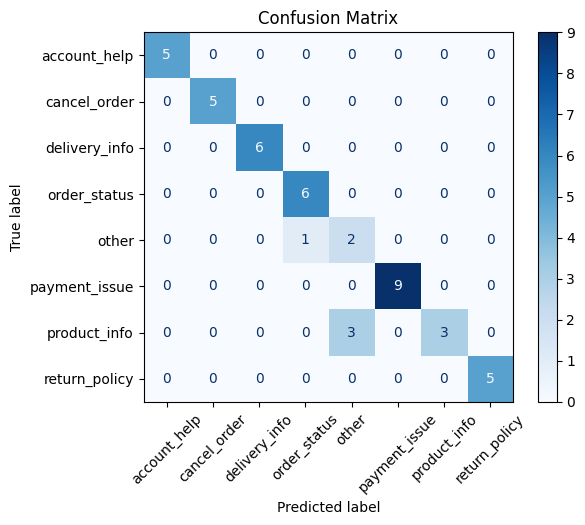

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you have y_test and y_pred already from the previous cell
# Use the 'model' variable which holds the trained Logistic Regression model
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

plt.figure(figsize=(10, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define a pipeline with TF-IDF and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression(max_iter=1000))
])

# Define hyperparameters to search
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l2'],
    'clf__solver': ['lbfgs']
}

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
print("✅ Best Parameters:")
print(grid_search.best_params_)

# Predict on test set
y_pred = grid_search.predict(X_test)

# Classification Report
from sklearn.metrics import classification_report
print("\n📊 Classification Report after Grid Search:")
print(classification_report(y_test, y_pred, zero_division=0))


Fitting 5 folds for each of 8 candidates, totalling 40 fits
✅ Best Parameters:
{'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'tfidf__ngram_range': (1, 1)}

📊 Classification Report after Grid Search:
               precision    recall  f1-score   support

 account_help       1.00      1.00      1.00         5
 cancel_order       1.00      1.00      1.00         5
delivery_info       1.00      1.00      1.00         6
 order_status       0.86      1.00      0.92         6
        other       0.40      0.67      0.50         3
payment_issue       1.00      1.00      1.00         9
 product_info       1.00      0.50      0.67         6
return_policy       1.00      1.00      1.00         5

     accuracy                           0.91        45
    macro avg       0.91      0.90      0.89        45
 weighted avg       0.94      0.91      0.91        45



In [ ]:
import joblib

# Save the best model
joblib.dump(grid_search.best_estimator_, 'chatbot_model.pkl')
print("✅ Model saved as 'chatbot_model.pkl'")


✅ Model saved as 'chatbot_model.pkl'


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

# Step 1: Load your cleaned dataset
df = pd.read_csv("/content/Cleaned_Split_Ecommerce_dataset.csv")
df.dropna(subset=['query'], inplace=True)

# Step 2: Create the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Step 3: Fit the vectorizer on the 'query' column (i.e., questions)
X = vectorizer.fit_transform(df['query'])

# Step 4: Save the fitted vectorizer as vectorizer.pkl
joblib.dump(vectorizer, 'vectorizer.pkl')

print("✅ TF-IDF vectorizer saved as 'vectorizer.pkl'")


✅ TF-IDF vectorizer saved as 'vectorizer.pkl'


In [ ]:
import joblib

# Load the saved model
model = joblib.load('chatbot_model.pkl')


In [ ]:
# Sample test
sample_queries = [
    "Where is my order?",
    "Can I return this product?",
    "How long does delivery take?",
    "What is the price of the mobile?"
]

# Predict intents
for query in sample_queries:
    predicted_intent = model.predict([query])[0]
    print(f"User: {query}")
    print(f"Predicted Intent: {predicted_intent}")
    print("-" * 40)


User: Where is my order?
Predicted Intent: order_status
----------------------------------------
User: Can I return this product?
Predicted Intent: return_policy
----------------------------------------
User: How long does delivery take?
Predicted Intent: other
----------------------------------------
User: What is the price of the mobile?
Predicted Intent: product_info
----------------------------------------


In [ ]:
import joblib

# Load the saved model
model = joblib.load('chatbot_model.pkl')

# Function to get chatbot response
def chatbot_response(user_input):
    return model.predict([user_input])[0]

# Simple chat loop
print("Chatbot: Hello! How can I assist you today?")
while True:
    # User input
    user_input = input("You: ")

    # Exit condition
    if user_input.lower() == 'exit':
        print("Chatbot: Goodbye! Have a great day!")
        break

    # Get and print chatbot response
    response = chatbot_response(user_input)
    print(f"Chatbot Intent: {response}")
    print("-" * 40)


Chatbot: Hello! How can I assist you today?
You: where is my order
Chatbot Intent: order_status
----------------------------------------
You: exit
Chatbot: Goodbye! Have a great day!


In [ ]:
import joblib # Import joblib instead of pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Load saved model and TF-IDF vectorizer using joblib
with open("chatbot_model.pkl", "rb") as model_file:
    model = joblib.load(model_file) # Load using joblib.load

# Assuming 'vectorizer.pkl' was created and saved separately
with open("vectorizer.pkl", "rb") as vec_file:
    vectorizer = joblib.load(vec_file) # Load using joblib.load

# Load dataset to fetch real responses
df = pd.read_csv("Cleaned_Split_Ecommerce_dataset.csv")
df.dropna(subset=['query'], inplace=True)

# Real-time prediction function
def chatbot_reply(user_input):
    user_input = str(user_input)
    user_vec = vectorizer.transform([user_input])
    dataset_vecs = vectorizer.transform(df['query'])

    # Compute cosine similarity
    sim_scores = cosine_similarity(user_vec, dataset_vecs).flatten()
    best_match_index = sim_scores.argmax()

    # Return response if similarity > threshold
    if sim_scores[best_match_index] > 0.3:
        return df['response'].iloc[best_match_index]
    else:
        return "Sorry, I didn't understand that. Could you please rephrase?"

# Test
while True:
    user_input = input("You: ")
    if user_input.lower() in ['exit', 'quit']:
        break
    print("Bot:", chatbot_reply(user_input))


Bot: you can cancel your order if it has not been shipped yet please contact our customer support team with your order details and we will assist you with the cancellation process
Bot: you can cancel your order if it has not been shipped yet please contact our customer support team with your order details and we will assist you with the cancellation process
Bot: to create an account click on the sign up button on the top right corner of our website and follow the instructions to complete the registration process
Bot: to create an account click on the sign up button on the top right corner of our website and follow the instructions to complete the registration process
Bot: you can track your order by logging into your account and navigating to the order history section there you will find the tracking information for your shipment
